# Deep Deterministic Policy Gradient (DDPG)

We introduce a python code for Deep Deterministic Policy Gradient (DDPG). Compared to methods using stochastic policy, where from given state $s$ the policy is defined as a probability distribution $\pi(\cdot|s)$ and the algorithm chooses one of the action based on that distribution, deterministic policy $\mu(s)$ provides a specific value from the given state $s$, hence called **deterministic**.  The paper can be found [here](https://arxiv.org/abs/1509.02971), and the code is modified from [This website](https://towardsdatascience.com/deep-deterministic-policy-gradients-explained-2d94655a9b7b)

In [3]:
import sys
import gym

import random
import numpy as np

import torch
import torch.autograd
import torch.nn            as nn
import torch.nn.functional as F 
import torch.optim         as optim
import matplotlib.pyplot   as plt
import moviepy.editor      as mpy

from collections import deque


/Users/mosesnah/Documents/projects/machine-learning-tutorial/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Actor and Critic Network (Separate)

For the DDPG algorithm, we split the Actor and Critic networks

## Critic 
The critic has four layers, and the critic learns the Q-function, $Q(s,a)$, hence the input is a concatenation of state and action, with a scalar output. 

## Actor
The actor network also has four layers, and it gets state vector as input and returns an action $a=\mu(s)$

In [4]:
class Critic( nn.Module ):

    def __init__( self, input_size, hidden_size, output_size ):

        super( Critic, self ).__init__()

        # First Layer, changes array with size N x ( input_size ) to N x ( hidden_size )
        self.linear1 = nn.Linear(  input_size, hidden_size )

        # Second Layer, changes array with size N x ( hidden_size ) to N x ( hidden_size )
        self.linear2 = nn.Linear( hidden_size, hidden_size )

        # Third Layer, changes array with size N x ( hidden_size ) to N x ( output_size )
        self.linear3 = nn.Linear( hidden_size, output_size )

    
    def forward( self, state, action ):

        # Concatenation of state and action vector.
        # The state  is assumed to be a 2D array with size N x n_s, where N is the number of samples
        # The action is assumed to be a 2D array with size N x n_a, where N is the number of samples
        # As a result of torch.cat( [ state, action ] along axis 1, ), we have size N x ( n_s + n_a ), and the dim = 0 must have the same size
        x = torch.cat( [ state, action ], dim = 1 )

        # Applying Rectified Linear Unit (ReLU) to x
        x = F.relu( self.linear1( x ) )

        # Applying Rectified Linear Unit (ReLU) to x
        x = F.relu( self.linear2( x ) )

        # A simple Ax + b combination 
        x = self.linear3( x )

        # The output is a N x 1 array. 
        return x

class Actor( nn.Module ):

    def __init__( self, input_size, hidden_size, output_size ):

        super( Actor, self ).__init__( )

        # First Layer, changes array with size N x ( input_size ) to N x ( hidden_size )
        self.linear1 = nn.Linear(  input_size, hidden_size )

        # Second Layer, changes array with size N x ( hidden_size ) to N x ( hidden_size )
        self.linear2 = nn.Linear( hidden_size, hidden_size )

        # Third Layer, changes array with size N x ( hidden_size ) to N x ( output_size )
        self.linear3 = nn.Linear( hidden_size, output_size )
        
    def forward( self, state ):
        
        # Applying Rectified Linear Unit (ReLU) to x
        x = F.relu( self.linear1( state ) )

        # Applying Rectified Linear Unit (ReLU) to x
        x = F.relu( self.linear2( x ) )

        # Applying to tanh, which ranges the value from -1 to +1
        x = torch.tanh( self.linear3( x ) ) 

        return x

actor1 = Actor( 3, 128, 1 )

tmp1 = actor1.forward( torch.FloatTensor( np.array( [1., 3., 3.] )  ) )

#tmp1 = actor1.forward( torch.FloatTensor( np.array( [1., 3., 3.] )  ).unsqueeze( 0 ) )
tmp1.detach( ).numpy( ) 

array([0.42400226], dtype=float32)

# Replay Buffer
As in Deep Q-Network (DQN), we construct a replay buffer. As mentioned in [this paper](https://arxiv.org/abs/1509.02971), optimization algorithms assume that the samples are independently and identically distributed, and the replay buffer addresses that problem. 

In [5]:
class Memory( object ):

    def __init__( self, max_size ):
        # deque is used to "forget" the values of the other end.
        # Meaning, for a deque with full capacity, if we append a new experience (to the right end) the element on the other end (i.e., the left end) is discarded. 
        self.buffer = deque( maxlen = max_size )
    
    def push( self, state, action, reward, next_state ):
        
        # We are making the reward as an array. 
        # Each element of the tuple has the following size:
        #      state: n_s
        #     action: n_a
        #     reward: 1 (but need to change from scalar to array)
        # next_state: n_s
        
        experience = ( state, action, np.array( [ reward ] ), next_state )

        # Insert the tuple of (S A R S) into to the right end of the buffer deque.
        self.buffer.append( experience )

    def sample( self, batch_size, type = 0 ):
        """
            Collect "batch_size" samples from the replay buffer and return it as a batch.
        """
        # The sample is simply an array of 
        # Sn An Rn+1 Sn+1
        # Where S, A and R are variables that are self-explanatory.  

        # Sample batch_size amount of list from the buffer
        # Returning a list of tuples
        
        batch = random.sample( self.buffer, batch_size ) 

        # The computation speed of Type 0 and 1 are quite similar. 
        if type == 0:
            
            # t_start = time.time( )

            state_batch      = [ ]
            action_batch     = [ ]
            reward_batch     = [ ]
            next_state_batch = [ ] 

            for experience in batch:
                
                state, action, reward, next_state = experience

                state_batch.append(       state      )
                action_batch.append(      action     )
                reward_batch.append(      reward     )
                next_state_batch.append(  next_state )

            # print( "[Method 1]", time.time( ) - t_start)  
            
            
        elif type == 1:

            # t_start = time.time( )

            # [REF] https://stackoverflow.com/questions/8081545/how-to-convert-list-of-tuples-to-multiple-lists
            tmp = list( zip( *batch ) )

            state_batch, action_batch, reward_batch, next_state_batch = tmp[ : ]

            # print( "[Method 2] ", time.time( ) - t_start ) 

        return state_batch, action_batch, reward_batch, next_state_batch
        
    def __len__( self ):
        return len( self.buffer )

# The Ornstein-Uhlenbeck Process

The Ornstein-Uhlenbeck Process generates noise that is correlated with the previous noise, as to prevent the noise from canceling out or “freezing” the overall dynamics. Adding this noise is mentioned in the [original paper](https://arxiv.org/abs/1509.02971). [Wikipedia](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process) provides a thorough explanation of the Ornstein-Uhlenbeck Process. The source code is from [this](https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py). The Ornstein-Uhlenbeck process with an additional drift term can be described as:
$$
    dx_t = \theta (\mu - x_t)dt + \sigma d W_t
$$
where $W_t$ denotes the [Wiener process](https://en.wikipedia.org/wiki/Wiener_process). 


In [6]:

class OUNoise( object ):
    
    def __init__( self, action_space, mu = 0.0, theta = 0.15, max_sigma = 0.3, min_sigma = 0.3, decay_period = 100000 ):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[ 0 ]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset( self ):
        # Caution! The state here is not the "pendulum"'s state, but the "noise" itself. 
        self.state = np.ones( self.action_dim ) * self.mu
        
    def evolve_state( self ):
        
        # Call the current noise value. 
        x  = self.state

        # randn returns a sample from the standard (i.e., normal) distribution
        dx = self.theta * ( self.mu - x ) + self.sigma * np.random.randn( self.action_dim )

        # Time-increment. x_{n+1} = x_{n} + dx
        self.state = x + dx

        return self.state
    
    def get_action( self, action, t = 0 ): 
        
        # Calculate the noise with respect to the given time. 
        ou_state   = self.evolve_state( )

        # For our case, we simply set the max_sigma and min_sigma the same, hence the sigma value is constant for us
        self.sigma = self.max_sigma - ( self.max_sigma - self.min_sigma ) * min( 1.0, t / self.decay_period )

        # Adding ou noise onto the action and then clipping it.
        return np.clip( action + ou_state, self.low, self.high )


class NormalizedEnv( gym.ActionWrapper ):
    """ 
        The pendulum v1's action min/max are -2/+2, respectively. 
        But the action output of tanh is -1 to +1, hence we need scale the action values between range [-2, +2] and [-1, +1]

        [REF] https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py
        [REF] https://github.com/openai/gym/blob/master/gym/core.py
        [REF] https://www.gymlibrary.ml/content/wrappers/
    """
 
    def action( self, act ):
        """
            Action range must change from [-1, +1] (The actor network's output) to [-2, +2], which will be the input to the gym.
            Hence, simply multiply 2. Note that this method does not work for other gym environments, where the range differs. 
        """

        return 2 * act
        

# DDPG Agent
Note that when we develop the actor and critic networks, we also make the copy of those networks, called actor-target and critic-target networks. The details are again, explained in [this paper](https://arxiv.org/abs/1509.02971).

The critic (or value) network is updated similarly as is done in Q-learning, where the target networks are employed. 
The loss function that are used for the policy gradient are defined as follows:
$$
    \text{Loss} = \frac{1}{N} \sum_{i=1}^{N} \big( y_i - Q( s_i, a_i | \theta^{Q}) \big )^2
$$
where $N$ is the sampled batch from the replay buffer. $y_i$ is defined as follows:
$$
    y_i = r_i + \gamma Q'\big( \; s_{i+1}, \; \mu'(s_{i+1} | \theta^{\mu'} ) | \theta^{Q'} \big)
$$
where comma superscript stands for the target network parameters. 

The actor network is updated with the following equation:
$$
    J( \theta ) = \mathbb{E} \big[ Q(s,a)|_{s=s_t, a = \mu(s_t)} \big]
$$

For the target networks, the parameters are "soft" updated with the following equations:
$$
\begin{align*}
    \theta^{Q'}   & \longleftarrow \tau \theta^{Q}   + ( 1 - \tau ) \theta^{Q'}   \\
    \theta^{\mu'} & \longleftarrow \tau \theta^{\mu} + ( 1 - \tau ) \theta^{\mu'} \\
\end{align*}
$$
where $\tau \in [0,1)$ and we should choose a small value (for our example, $\tau=0.01$ )

In [7]:

class DDPGagent( object ):
    def __init__( self, env, hidden_size = 256, actor_learning_rate = 1e-3, critic_learning_rate = 1e-3, gamma = 0.99, tau = 1e-2, max_memory_size = 50000 ):

        # The n_s and n_a of the system
        self.n_states  = env.observation_space.shape[ 0 ]
        self.n_actions = env.action_space.shape[ 0 ]

        # Actor Network and its target Network
        self.actor        = Actor( self.n_states, hidden_size, self.n_actions )
        self.actor_target = Actor( self.n_states, hidden_size, self.n_actions )

        # Critic Network and its target Network
        self.critic        = Critic( self.n_states + self.n_actions, hidden_size, self.n_actions )
        self.critic_target = Critic( self.n_states + self.n_actions, hidden_size, self.n_actions )

        self.gamma = gamma
        self.tau   = tau

        for target_param, param in zip( self.actor_target.parameters( ), self.actor.parameters( ) ):

            # Copy the parameters of the main actor parameters to the target parameters
            target_param.data.copy_( param.data )

        for target_param, param in zip( self.critic_target.parameters( ), self.critic.parameters( ) ):

            # Copy the parameters of the main critic parameters to the target parameters
            target_param.data.copy_( param.data )
        
        # Construct the replay-buffer. 
        self.memory = Memory( max_memory_size )      

        # Define the optimizers and the loss function. 
        self.critic_criterion  = nn.MSELoss( )
        self.actor_optimizer   = optim.Adam(  self.actor.parameters( ), lr =  actor_learning_rate )
        self.critic_optimizer  = optim.Adam( self.critic.parameters( ), lr = critic_learning_rate )
    
    def get_action( self, state ):

        # Conduct the a = mu(s), where mu is a "deterministic function"
        # Unsqueeze makes an 1 x n_s array of state. 
        state  = torch.from_numpy( state ).float( ).unsqueeze( 0 )

        # Returns an 1 x n_a array of state
        action = self.actor.forward( state )

        # Change action from Torch to Numpy.
        # Since n_a is 1 for this case, action is simply an 1x1 array.
        # Thus, choosing the ( 0, 0 )th element for the action
        action = action.detach( ).numpy( )[ 0,0 ]

        return action
    
    def update( self, batch_size ):
        """
            Mini-batch update. 
        """
        # Randomly sample batch_size numbers of S A R S.
        states, actions, rewards, next_states = self.memory.sample( batch_size , type = 0 )

        # Creating a tensor from a list of numpy.ndarrays is extremely slow. 
        # Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. 
        # A list with N of Ns-size arrays will become an N x Ns 2D array, to tensor with "float" data. 
        states      = torch.FloatTensor( np.array( states      )  )
        actions     = torch.FloatTensor( np.array( actions     )  )
        rewards     = torch.FloatTensor( np.array( rewards     )  )
        next_states = torch.FloatTensor( np.array( next_states )  )
    

        # Critic loss 
        Qvals        = self.critic.forward( states, actions )
        next_actions = self.actor_target.forward( next_states )
        next_Q       = self.critic_target.forward( next_states, next_actions.detach( ) )
        Qprime       = rewards + self.gamma * next_Q

        critic_loss  = self.critic_criterion( Qvals, Qprime )

        # Actor loss, it is simply the mean of the Q function 
        policy_loss = - self.critic.forward( states, self.actor.forward( states ) ).mean( )
        
        # Update Actor network
        self.actor_optimizer.zero_grad( )
        policy_loss.backward( )
        self.actor_optimizer.step( )

        # Update Critic network
        self.critic_optimizer.zero_grad( )
        critic_loss.backward( ) 
        self.critic_optimizer.step( )

        # The "soft" update of target networks
        for target_param, param in zip( self.actor_target.parameters( ), self.actor.parameters( ) ):
            target_param.data.copy_( param.data * self.tau + target_param.data * ( 1.0 - self.tau ) )
       
        for target_param, param in zip( self.critic_target.parameters( ), self.critic.parameters( ) ):
            target_param.data.copy_( param.data * self.tau + target_param.data * ( 1.0 - self.tau ) )


In [8]:
# Define instances of the environment, DDPG agent and the OU noise.
env   = NormalizedEnv( gym.make( "Pendulum-v1" )  )
agent = DDPGagent( env )
noise = OUNoise( env.action_space )

# The number of "batch" that will be sampled from the replay buffer will be "batch_size" 
batch_size  = 128

# Saving these values to plot the performance at the end.

frames        = [ ]
whole_rewards = [ ]

# Flags for turning on or off the render.
is_save_video = False
is_save_model = True

best_model_val = -3254

for _ in range( 10 ):

    rewards       = [ ]
    avg_rewards   = [ ]

    for episode in range( 500 ):

        # Initialize the gym environment and OU noise 
        state = env.reset()
        noise.reset( )

        # Initialize the episode's reward
        episode_reward = 0
        
        # A single simulation is maximum 200-steps long. 
        for step in range( 500 ):

            # Get the action value from the deterministic policy Actor network.
            action = agent.get_action( state )

            if is_save_video : frames.append( env.render( mode = 'rgb_array' ) )


            # Apply the OU noise on this action
            action = noise.get_action( action, step )

            # Run a single step of simulation
            new_state, reward, done, _ = env.step( action )  

            # Add this to our replay buffer, note that push simply generates the tuple and add 
            agent.memory.push( state, action, reward, new_state )
            
            # Once the agent memory is full, then update the policy via replay buffer.
            if len( agent.memory ) > batch_size: agent.update( batch_size )        
            
            # Update the state and reward value 
            state = new_state
            episode_reward += reward

            if done:
                break

        if best_model_val <= episode_reward:
            best_model_val = episode_reward 

            # If this policy has a good result, save it 
            if is_save_model: torch.save( agent.actor, '../models/DDPG_best_model.pth') 

        # Once a single simulation is done, append the values that will be plotted later
        rewards.append( episode_reward )
        avg_rewards.append( np.mean( rewards[ -10 : ] ) )

        sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format( episode, np.round( episode_reward, decimals = 2 ), avg_rewards[ -1 ] ) ) 

    whole_rewards.append(  rewards  )

env.close( )

if is_save_video:
    clip = mpy.ImageSequenceClip( frames, fps = 30 )
    clip.write_gif( "../videos/DDPG.gif" )



episode: 0, reward: -1175.71, average _reward: -1175.714370455748 
episode: 1, reward: -1635.0, average _reward: -1405.356026634767 
episode: 2, reward: -1632.05, average _reward: -1480.9208990376585 
episode: 3, reward: -1557.52, average _reward: -1500.0694527743522 
episode: 4, reward: -1151.85, average _reward: -1430.426186793206 
episode: 5, reward: -1037.25, average _reward: -1364.8963143764893 
episode: 6, reward: -1221.07, average _reward: -1344.3500899411574 
episode: 7, reward: -659.91, average _reward: -1258.794522260142 
episode: 8, reward: -755.56, average _reward: -1202.8797822893948 
episode: 9, reward: -753.87, average _reward: -1157.9783828992254 
episode: 10, reward: -504.95, average _reward: -1090.9021519611024 
episode: 11, reward: -381.93, average _reward: -965.5951917347545 
episode: 12, reward: -620.6, average _reward: -864.4497899142534 
episode: 13, reward: -493.18, average _reward: -758.0165129024333 
episode: 14, reward: -380.98, average _reward: -680.92873820

KeyboardInterrupt: 

# Plotting the Results

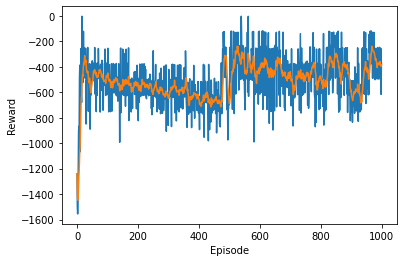

In [ ]:

plt.plot( rewards     )
plt.plot( avg_rewards )
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

# Running the best model 

In [ ]:
is_save_video = True

env   = NormalizedEnv( gym.make( "Pendulum-v1" )  )

model_path = "../models/DDPG_best_model.pth"

# Load the pyTorch Model
model = torch.load( model_path )

# Run trial
state = env.reset()   

frames = []
# The maximum trial is 500 for the cart-and-pole
for _ in range( 500 ):

    if is_save_video: frames.append( env.render( mode = "rgb_array")  )
    env.render( )

    # Get the choice of action and the pi( a_t | s_t ) for the gradient calculation
    action, _ = model.get_action( state )
    new_state, _, done, _ = env.step( action )

    # If the trail encounters the terminal state
    if done: 
        break
    state = new_state

# Save Video
env.close( )

if is_save_video:
    clip = mpy.ImageSequenceClip( frames, fps = 30 )
    clip.write_gif( "../videos/circle.gif" )

NameError: name 'NormalizedEnv' is not defined